In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [30]:
# Used to add labels to histogram
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


In [31]:
# Loading in initial datasets
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

## Performing a quick investigation of data in our two dataframes

In [4]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [32]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Exploring the distribution of choice_0 requests below, Xmas Eve is the overwhelming choice and weekends (Fri-Sun) are popular as well

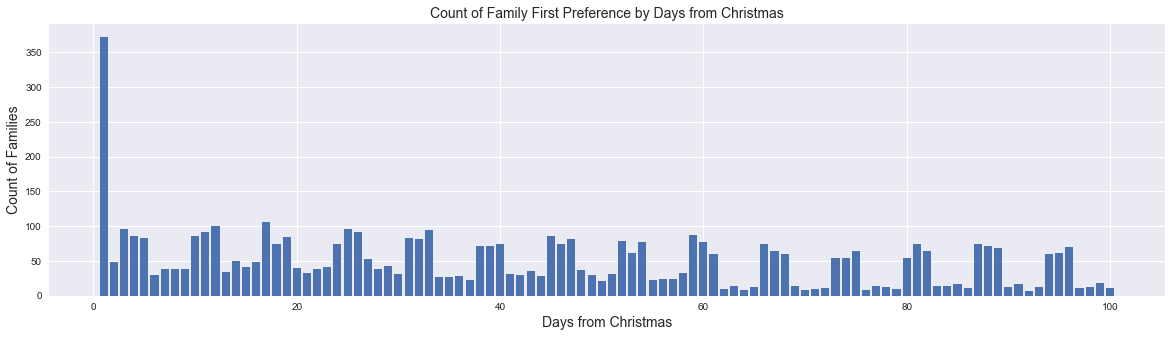

In [52]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas',fontsize=14)
ax.set_ylabel('Count of Families',fontsize=14)
ax.set_title('Count of Family First Preference by Days from Christmas',fontsize=14)

bar = ax.bar(data.groupby('choice_0')['choice_0'].count().index,data.groupby('choice_0')['choice_0'].count().values)

## Validating most preferences are for Friday, Saturday, Sunday. Tuesday is Christmas Eve

In [6]:
# Setting base date as Christmas Eve
import datetime
base = datetime.datetime(2019,12,24,00)

# Creating datelist for all 100 days before christmas
date_list = [base - datetime.timedelta(days=x) for x in range(100)]

# Creating date dataframe with day of week number (0 = Monday)
date_index = pd.DataFrame(date_list,columns=['date'])
date_index['day'] = date_index['date'].apply(lambda x: x.dayofweek)
date_index.index += 1 #aligning the index to days before Xmas

date_dict = date_index.day.to_dict()
data_day = data[['choice_0']]
data_day['choice_0_day']= data_day['choice_0'].map(date_dict)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


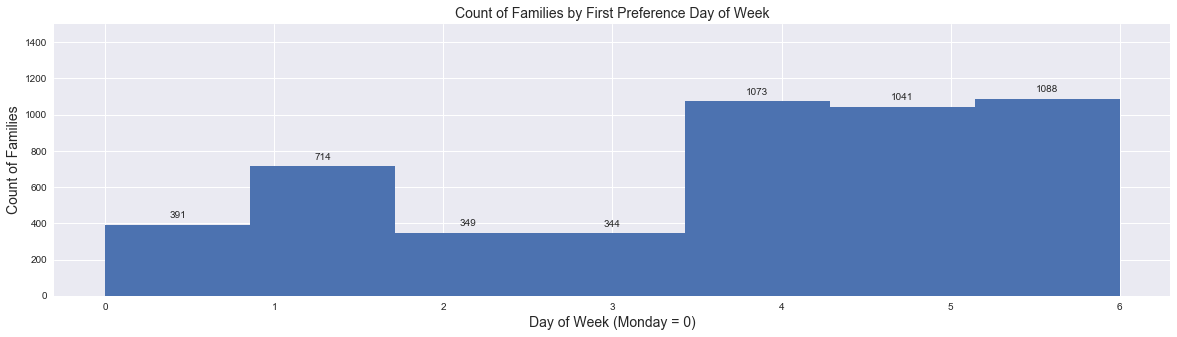

In [51]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Day of Week (Monday = 0)',fontsize=14)
ax.set_ylabel('Count of Families',fontsize=14)
ax.set_title('Count of Families by First Preference Day of Week',fontsize=14)

hist = ax.hist(data_day['choice_0_day'].astype('int'),bins=7)
ax.set(ylim=(0,1500))


add_value_labels(ax)


In [9]:
# Creating a current preference list to add as a column to starting submission dataframe
columns = list(data.columns)[1:11]
preference = []

for index in submission.index:
    day = submission.loc[index].values[0]
    temp_list = list(data.loc[index,columns].values) #loc gets column values at the specific index
    if day not in temp_list:
        preference.append(10)
    else:
        preference.append(int(temp_list.index(day)))

In [10]:
# Adding some columns to submission for visualization and analysis
submission['preference'] = preference
submission['n_people'] = data['n_people']

In [11]:
# Given cost function for families not getting their desired preferences
def top_pref_penalty(d,n):
    
    penalty = 0
    
    d = d
    if d == 0:
        penalty += 0
    elif d == 1:
        penalty += 50
    elif d == 2:
        penalty += 50 + 9 * n
    elif d == 3:
        penalty += 100 + 9 * n
    elif d == 4:
        penalty += 200 + 9 * n
    elif d == 5:
        penalty += 200 + 18 * n
    elif d == 6:
        penalty += 300 + 18 * n
    elif d == 7:
        penalty += 300 + 36 * n
    elif d == 8:
        penalty += 400 + 36 * n
    elif d == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

## Looking at how cost changes based on preference, ensuring people do not get choice 9 or no choice is ideal to keep cost down

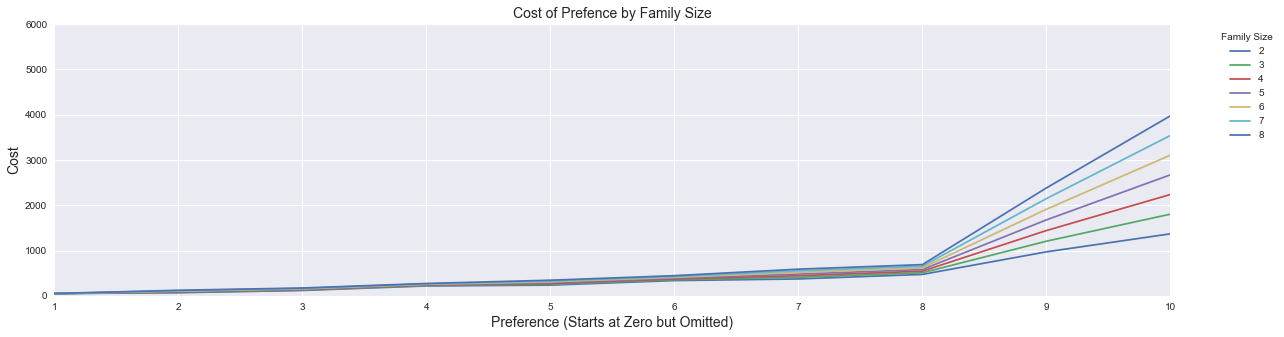

In [53]:
# Setting average family size
fam_size = sorted(list(data['n_people'].unique()))
pref = range(1,11)

# Labels for stacked plot
labels = fam_size

fam_size_2 = [top_pref_penalty(d,2) for d in pref]
fam_size_3 = [top_pref_penalty(d,3) for d in pref]
fam_size_4 = [top_pref_penalty(d,4) for d in pref]
fam_size_5 = [top_pref_penalty(d,5) for d in pref]
fam_size_6 = [top_pref_penalty(d,6) for d in pref]
fam_size_7 = [top_pref_penalty(d,7) for d in pref]
fam_size_8 = [top_pref_penalty(d,8) for d in pref]


# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Preference (Starts at Zero but Omitted)',fontsize=14)
ax.set_ylabel('Cost',fontsize=14)
ax.set_title('Cost of Prefence by Family Size',fontsize=14)
ax.set_ylim(0,6000)
ax.set_xlim(1,10)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pref,fam_size_2)
ax2 = ax.plot(pref,fam_size_3)
ax3 = ax.plot(pref,fam_size_4)
ax4 = ax.plot(pref,fam_size_5)
ax5 = ax.plot(pref,fam_size_6)
ax6 = ax.plot(pref,fam_size_7)
ax7 = ax.plot(pref,fam_size_8)

ax.legend(labels=labels,loc=1,bbox_to_anchor=(1.1, 1),title='Family Size')

plt.show()

## Our initial schedule has most families not receiving any of their preferences...

In [13]:
def pref_count(df,pref):
    
    if pref == 11:
        pref_df = df[['assigned_day','n_people']].groupby('assigned_day').sum()
    else:
        pref_df = df[df['preference'] == pref][['assigned_day','n_people']].groupby('assigned_day').sum()
    
    count = [0]*100

    for index,row in pref_df.iterrows():
        index = index - 1
        count[index] = row['n_people']

    return count

In [54]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(np.sort(submission.preference.unique()))

# Creating individual lists for each preference (required for stacked plot)
pref_0 = pref_count(submission,0)
pref_1 = pref_count(submission,1)
pref_2 = pref_count(submission,2)
pref_3 = pref_count(submission,3)
pref_4 = pref_count(submission,4)
pref_5 = pref_count(submission,5)
pref_6 = pref_count(submission,6)
pref_7 = pref_count(submission,7)
pref_8 = pref_count(submission,8)
pref_9 = pref_count(submission,9)
pref_10 = pref_count(submission,10)

# Getting days from Occupancy dataframe
x = list(range(1,101))

# Setting figure
fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas',fontsize=14)
ax.set_ylabel('Occupancy',fontsize=14)
ax.set_title('Occupancy per Day by Preference Given',fontsize=14)
ax.set_ylim(0,400)
ax.set_xlim(0,100)

# Creating plot
ax.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1,bbox_to_anchor=(1.1, 1))

plt.show()

AttributeError: 'DataFrame' object has no attribute 'preference'

In [15]:
# Calculating preference penalty
submission['pref_pen'] = 0
submission['pref_pen'] = submission.apply(lambda x: top_pref_penalty(x['preference'],x['n_people']),axis=1)

In [29]:
# Creating occupancy dataframe to constrain daily limits and calculate accounting costs
occupancy = pd.DataFrame()
occupancy['daily_vol'] = pref_count(submission,11)
occupancy['acct_cost'] = 100000 # preset a large value to optimize
occupancy.index += 1

In [18]:
# Calculating accounting costs

days = list(range(100,0,-1))

# First day is special
occupancy.loc[days[0]]['acct_cost'] = (occupancy.loc[days[0]]['daily_vol']-125.0) / 400.0 *\
                                       occupancy.loc[days[0]]['daily_vol']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['daily_vol']
for day in days[1:]:
    
    today_count = occupancy.loc[day]['daily_vol']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0., (occupancy.loc[day]['daily_vol']-125.0) / 400.0 *\
                                              occupancy.loc[day]['daily_vol']**(0.5 + diff / 50.0))
    yesterday_count = today_count

## Exploring Accounting Cost, we see Accounting Cost rises exponentially as the daily delta rises. It would behoove us to minimize daily deltas and stay within 20-30 people as the previous day

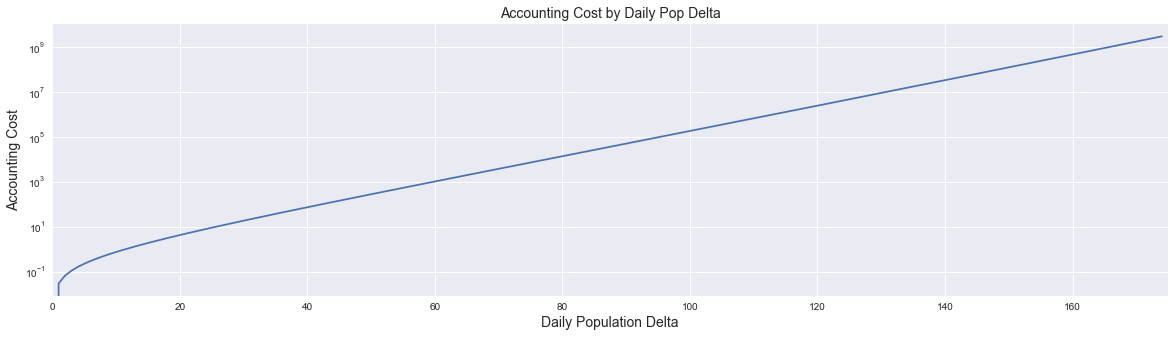

In [55]:
pop_range = range(125,300)

cost = [max(0, (x-125.0) / 400.0 * x**(0.5 + (x-125) / 50.0)) for x in pop_range]
        
pop_delta = range(0,175)

# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Daily Population Delta',fontsize=14)
ax.set_ylabel('Accounting Cost',fontsize=14)
ax.set_title('Accounting Cost by Daily Pop Delta',fontsize=14)
ax.set_yscale('log')
ax.set_xlim(0,175)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pop_delta,cost)

plt.show()

In [20]:
submission2 = submission.copy()
columns = ['choice_0','choice_1','choice_2','choice_3','choice_4',\
           'choice_5','choice_6','choice_7','choice_8','choice_9']

max_count = 225 # Setting this too may not allow you to add ideal preferences to the right days due to daily limits
min_count = 125
max_daily_change = 100

for index,row in submission2.iterrows():
    pref = 0
    
    occupancy = pd.DataFrame()
    occupancy['daily_vol'] = pref_count(submission2,11)
    occupancy.index += 1
    
    current_day = row['assigned_day']
    
    if row['assigned_day'] == 100:
        prev_day = 100
    else:
        prev_day = row['assigned_day'] + 1
    
    for day in list(data[columns].loc[index].values):
        
        if day == 100: # Skipping preference of Day 0 for now
            prev_day_selection = 100
        else:
            prev_day_selection = day+1
            
            
        if occupancy.loc[day]['daily_vol'] + row['n_people'] <= max_count and\
            occupancy.loc[current_day]['daily_vol'] - row['n_people'] >= min_count and\
            abs(occupancy.loc[current_day]['daily_vol'] - row['n_people'] - occupancy.loc[prev_day]['daily_vol']) <= max_daily_change and\
            abs(occupancy.loc[day]['daily_vol'] + row['n_people'] - occupancy.loc[prev_day_selection]['daily_vol']) <= max_daily_change:

            submission2.loc[index]['assigned_day'] = day
            submission2.loc[index]['preference'] = pref

            break

        else:
            pref += 1
            pass

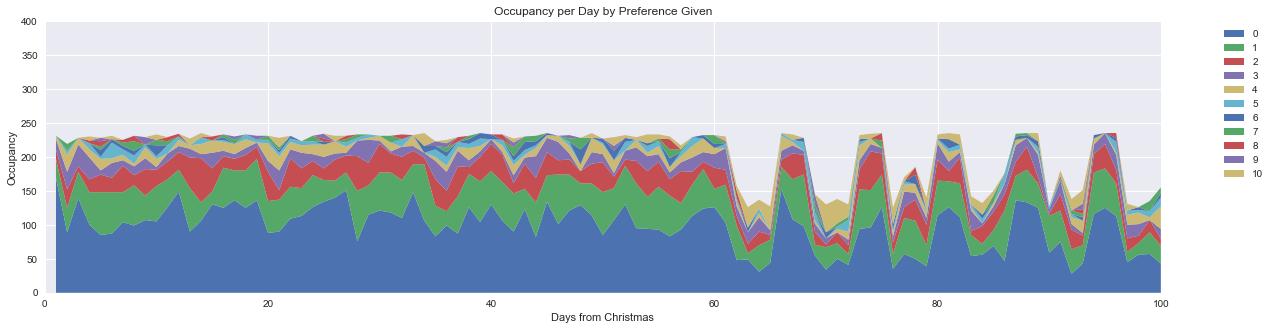

In [21]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(np.sort(submission2.preference.unique()))

# Creating individual lists for each preference (required for stacked plot)
pref_0 = pref_count(submission2,0)
pref_1 = pref_count(submission2,1)
pref_2 = pref_count(submission2,2)
pref_3 = pref_count(submission2,3)
pref_4 = pref_count(submission2,4)
pref_5 = pref_count(submission2,5)
pref_6 = pref_count(submission2,6)
pref_7 = pref_count(submission2,7)
pref_8 = pref_count(submission2,8)
pref_9 = pref_count(submission2,9)
pref_10 = pref_count(submission2,10)

# Getting days from Occupancy dataframe
x = list(range(1,101))

# Setting figure
fig, ax1 = plt.subplots(figsize=(20,5))

# Formatting plot area
ax1.set_xlabel('Days from Christmas',fontsize=14)
ax1.set_ylabel('Occupancy',fontsize=14)
ax1.set_title('Occupancy per Day by Preference Given',fontsize=14)
ax1.set_ylim(0,400)
ax1.set_xlim(0,100)

# Creating plot
ax1.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax1.legend(loc=1,bbox_to_anchor=(1.1, 1))

plt.show()

In [22]:
submission2['pref_pen'] = submission2.apply(lambda x: top_pref_penalty(x['preference'],x['n_people']),axis=1)

occupancy = pd.DataFrame()
occupancy['daily_vol'] = pref_count(submission2,11)
occupancy['acct_cost'] = 10000000
occupancy.index += 1

days = list(range(100,0,-1))

# First day is special
occupancy.loc[days[0]]['acct_cost'] = (occupancy.loc[days[0]]['daily_vol']-125.0) / 400.0 *\
                                       occupancy.loc[days[0]]['daily_vol']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['daily_vol']
for day in days[1:]:
    
    today_count = occupancy.loc[day]['daily_vol']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0., (occupancy.loc[day]['daily_vol']-125.0) / 400.0 *\
                                              occupancy.loc[day]['daily_vol']**(0.5 + diff / 50.0))
    yesterday_count = today_count

In [23]:
# Calculating un-optimized score
score = submission2['pref_pen'].sum() + occupancy['acct_cost'].sum()

print('{0:,}'.format(score))

2,346,184


In [24]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}

    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

In [25]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [26]:
# Start with the un-optimized submission values
best = submission2['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission2['assigned_day'] = new
score = cost_function(new)
# submission2.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

Score: 253271.6412796804


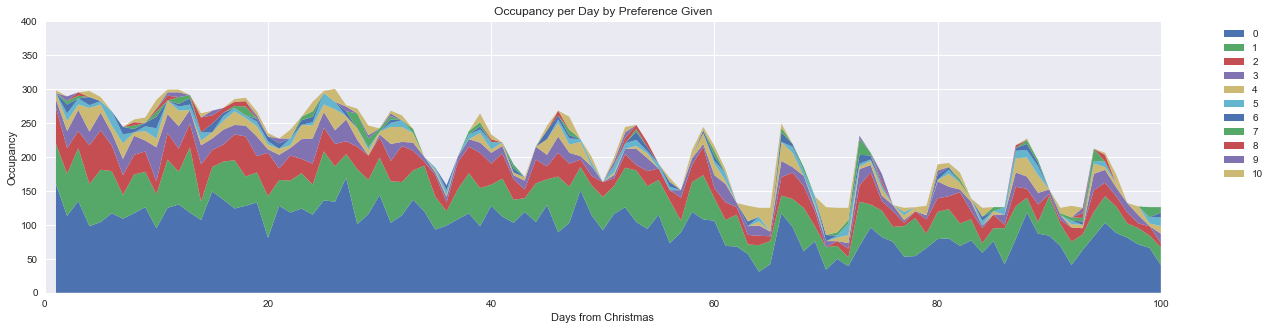

In [27]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(np.sort(submission2.preference.unique()))

# Creating individual lists for each preference (required for stacked plot)
pref_0 = pref_count(submission2,0)
pref_1 = pref_count(submission2,1)
pref_2 = pref_count(submission2,2)
pref_3 = pref_count(submission2,3)
pref_4 = pref_count(submission2,4)
pref_5 = pref_count(submission2,5)
pref_6 = pref_count(submission2,6)
pref_7 = pref_count(submission2,7)
pref_8 = pref_count(submission2,8)
pref_9 = pref_count(submission2,9)
pref_10 = pref_count(submission2,10)

# Getting days from Occupancy dataframe
x = list(range(1,101))

# Setting figure
fig, ax1 = plt.subplots(figsize=(20,5))

# Formatting plot area
ax1.set_xlabel('Days from Christmas',fontsize=14)
ax1.set_ylabel('Occupancy',fontsize=14)
ax1.set_title('Occupancy per Day by Preference Given',fontsize=14)
ax1.set_ylim(0,400)
ax1.set_xlim(0,100)

# Creating plot
ax1.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax1.legend(loc=1,bbox_to_anchor=(1.1, 1))

plt.show()

In [28]:
# Iterate to lower the cost

# Initiating previous scores for loop convergence
prev1_score = 100000000000
prev2_score = 999999999999

for i in range(100):

    best = submission2['assigned_day'].tolist()
    start_score = cost_function(best)

    new = best.copy()
    # loop over each family
    for fam_id, _ in enumerate(best):
        # loop over each family choice
        for pick in range(10):
            day = choice_dict[f'choice_{pick}'][fam_id]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            if cost_function(temp) < start_score:
                new = temp.copy()
                start_score = cost_function(new)

    submission2['assigned_day'] = new
    prev2_score = prev1_score
    prev1_score = score
    score = cost_function(new)
    
    print(f'Score: {score}')
    
    # Once scores converge, break loop
    if prev2_score == prev1_score == score:
        break

Score: 230718.97811391822
Score: 220898.2329616138
Score: 215429.20694287115


KeyboardInterrupt: 

In [ ]:
# Creating a new preference list to update preference column in submission dataframe
columns = list(data.columns)[0:10]
preference = []

for index in submission2.index:
    day = submission2.loc[index].values[0]
    temp_list = list(data.loc[index,columns].values) #loc gets column values at the specific index
    if day not in temp_list:
        preference.append(10)
    else:
        preference.append(int(temp_list.index(day)))
        
# Adding some columns to submission for visualization and analysis
submission2['preference'] = preference

In [ ]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(np.sort(submission2.preference.unique()))

# Creating individual lists for each preference (required for stacked plot)
pref_0 = pref_count(submission2,0)
pref_1 = pref_count(submission2,1)
pref_2 = pref_count(submission2,2)
pref_3 = pref_count(submission2,3)
pref_4 = pref_count(submission2,4)
pref_5 = pref_count(submission2,5)
pref_6 = pref_count(submission2,6)
pref_7 = pref_count(submission2,7)
pref_8 = pref_count(submission2,8)
pref_9 = pref_count(submission2,9)
pref_10 = pref_count(submission2,10)

# Getting days from Occupancy dataframe
x = list(range(1,101))

# Setting figure
fig, ax1 = plt.subplots(figsize=(20,5))

# Formatting plot area
ax1.set_xlabel('Days from Christmas',fontsize=14)
ax1.set_ylabel('Occupancy',fontsize=14)
ax1.set_title('Occupancy per Day by Preference Given',fontsize=14)
ax1.set_ylim(0,400)
ax1.set_xlim(0,100)

# Creating plot
ax1.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax1.legend(loc=1,bbox_to_anchor=(1.1, 1))

plt.show()

In [ ]:
score

In [ ]:
# Create CSV to submit
submission2[['assigned_day']].to_csv(f'submission_{score}.csv')

## Final Thoughts:

Lessons Learned:
1. Simplifying the structure to work off one (submissions dataframe) source reduced the amount of overall coding and also reduced errors. All re-calculations of cost and occupancy per day were done with re-created dataframes (where needed) at each step.
2. Setting initial assigned days based off absolute daily limits did not allow optimization functions any flexibility to add families to preferred buckets'
3. Creating cost, volume aggregation, and prference functions allowed for modular code to be added to new versions, code collapsing for simplified view, and easier calculations throughout
4. Creating cost optimization loop with convergence check stops processing when cost reduction is done

Future Improvements:
1. Hyper parameter tuning using Grid Search(?) would allow for tuning initial daily limit and daily delta variables to reach best score with this approach
2. Randomizing the family_id and preference list then optimizing each could improve scoring as opposed to always running through family_ids and preferences in order
3. Explore optimization package options to reach absolute best score
4. Possible removal of loops or other approaches to gain compute efficiency (this takes up to an hour to run)
4. Could better target more preferred days and weekends